# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [202]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # Todo: request the data from the data url
    # Hint: use `requests.get` method
    r = requests.get(url, stream=True)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [143]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [144]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

/tmp/ipykernel_227/4281747999.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [145]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [146]:
# Feel free to explore the datasets

dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [147]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [148]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [149]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

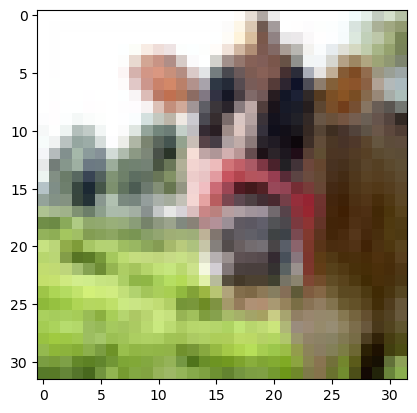

In [150]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [151]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [152]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [153]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [154]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [155]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [156]:
import pandas as pd

# Todo: Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
# Step 1: Create a DataFrame from fine_label_names
fine_labels = pd.DataFrame(dataset_meta[b'fine_label_names'], columns=["label_name"])

# Step 2: Decode the byte strings to normal strings
fine_labels["label_name"] = fine_labels["label_name"].apply(lambda x: x.decode("utf-8"))

# Step 3: Add label numbers (index values)
fine_labels["label_number"] = fine_labels.index

# Step 4: Now filter for Bicycle and Motorcycle
bicycle_label = fine_labels[fine_labels["label_name"] == "bicycle"]["label_number"].values[0]
motorcycle_label = fine_labels[fine_labels["label_name"] == "motorcycle"]["label_number"].values[0]

# Step 5: Print the label numbers
print(f"Bicycle Label Number: {bicycle_label}")
print(f"Motorcycle Label Number: {motorcycle_label}")

# (Optional) Show the table
fine_labels.head(30)  # See the first 30 labels to verify


Bicycle Label Number: 8
Motorcycle Label Number: 48


,label_name,label_number
0,apple,0
1,aquarium_fish,1
2,baby,2
3,bear,3
4,beaver,4
5,bed,5
6,bee,6
7,beetle,7
8,bicycle,8
9,bottle,9


Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [157]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train["labels"].isin([8, 48])] #TODO: Fill in

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test["labels"].isin([8, 48])] #TODO: Fill in

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, we can save all our images.

In [158]:
!mkdir ./train
!mkdir ./test

mkdir: cannot create directory ‘./train’: File exists
mkdir: cannot create directory ‘./test’: File exists


In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [159]:
import os
def save_images(df, dataset, path="./train/"):
    for idx, row in df.iterrows():
        # Grab the image data in row-major form
        img = dataset[b'data'][row['row']]

        # Consolidated stacking/reshaping
        target = np.dstack((
            img[0:1024].reshape(32,32),
            img[1024:2048].reshape(32,32),
            img[2048:].reshape(32,32)
        ))

        # Determine subfolder based on label
        label_folder = "bicycle" if row["labels"] == 8 else "motorcycle"
        save_path = os.path.join(path, label_folder)

        # Make sure subfolder exists
        os.makedirs(save_path, exist_ok=True)

        # Save the image
        plt.imsave(os.path.join(save_path, row['filenames']), target)

    # Return something if you want, e.g., number of images saved
    return len(df)

# Create main folders if not exist
os.makedirs("./train", exist_ok=True)
os.makedirs("./test", exist_ok=True)

# Save train images
save_images(df_train, dataset_train, path="./train/")

# Save test images
save_images(df_test, dataset_test, path="./test/")

200

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [160]:
import sagemaker
from sagemaker import get_execution_role

# Get the SageMaker session
sagemaker_session = sagemaker.Session()

# Get the default S3 bucket (you can also create a specific one manually if needed)
bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

# Get the AWS region
region = sagemaker_session.boto_region_name
print("AWS Region: {}".format(region))

# Get the execution role
role = get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-620425758198
AWS Region: us-east-1
RoleArn: arn:aws:iam::620425758198:role/service-role/AmazonSageMaker-ExecutionRole-20250428T181507


With this data we can easily sync your data up into S3!

In [161]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle/bicycle_s_000017.png to s3://sagemaker-us-east-1-620425758198/train/bicycle/bicycle_s_000017.png
upload: train/bicycle/bicycle_s_000124.png to s3://sagemaker-us-east-1-620425758198/train/bicycle/bicycle_s_000124.png
upload: train/bicycle/bicycle_s_000038.png to s3://sagemaker-us-east-1-620425758198/train/bicycle/bicycle_s_000038.png
upload: train/bicycle/bicycle_s_000021.png to s3://sagemaker-us-east-1-620425758198/train/bicycle/bicycle_s_000021.png
upload: train/bicycle/bicycle_s_000099.png to s3://sagemaker-us-east-1-620425758198/train/bicycle/bicycle_s_000099.png
upload: train/bicycle/bicycle_s_000039.png to s3://sagemaker-us-east-1-620425758198/train/bicycle/bicycle_s_000039.png
upload: train/bicycle/bicycle_s_000137.png to s3://sagemaker-us-east-1-620425758198/train/bicycle/bicycle_s_000137.png
upload: train/bicycle/bicycle_s_000051.png to s3://sagemaker-us-east-1-620425758198/train/bicycle/bicycle_s_000051.png
upload: train/bicycle/bicycle_s_000147.png to s3

And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [162]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [163]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [164]:
from sagemaker import image_uris

# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = image_uris.retrieve(framework='image-classification', region=region)
s3_output_location = f"s3://{bucket}/models/image_model"

print("Algorithm Image URI:", algo_image)
print("Model Output Location:", s3_output_location)

[04/28/25 15:53:57] INFO     Same images used for training and inference. Defaulting to image     ]8;id=929487;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=692764;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=833374;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=31071;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

Algorithm Image URI: 811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1
Model Output Location: s3://sagemaker-us-east-1-620425758198/models/image_model


We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [165]:
img_classifier_model = sagemaker.estimator.Estimator(
    image_uri=algo_image,
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",  # Using the powerful GPU instance for training
    volume_size=50,                 # 50 GB of EBS storage
    max_run=3600,                   # Max training time (1 hour)
    output_path=s3_output_location, # The output location we defined earlier
    sagemaker_session=sagemaker.Session()
)

We can also set a few key hyperparameters and define the inputs for our model:

In [166]:
img_classifier_model.set_hyperparameters(
    image_shape="3,32,32",  # The input image shape (3 channels, 32x32 pixels)
    num_classes=2,          # Number of classes: 2 (bicycle and motorcycle)
    num_training_samples=len(df_train)  # Number of training samples (filtered for bicycles and motorcycles)
)

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [167]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [170]:
import boto3
import pandas as pd

# 1. (Re)build s3_path and binary labels on your original dfs:
for df in [df_train, df_test]:
    df["s3_path"]      = df["labels"].map({8:"bicycle", 48:"motorcycle"}) + "/" + df["filenames"]
    df["label_binary"] = df["labels"].map({8:0,    48:1})

# 2. Find exactly which image keys exist in S3:
bucket = "sagemaker-us-east-1-620425758198"
s3 = boto3.client("s3")
existing = set()
for prefix in ["train/", "test/"]:
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            key = obj["Key"]
            if not key.endswith("/"):
                # store the relative part under train/ or test/
                existing.add(key[len(prefix):])

# 3. Filter out any rows whose s3_path isn't actually in the bucket:
df_train_clean = df_train[df_train["s3_path"].isin(existing)].reset_index(drop=True)
df_test_clean  = df_test [df_test ["s3_path"].isin(existing)].reset_index(drop=True)

# 4. Write out NEW .lst files with (new_row_index, label_binary, s3_path):
for df_clean, name in [(df_train_clean, "train"), (df_test_clean, "test")]:
    df_clean["row"] = df_clean.index  # make a fresh 0..N-1 index
    df_clean[["row", "label_binary", "s3_path"]].to_csv(
        f"{name}.lst", sep="\t", index=False, header=False
    )

# 5. Upload the fresh manifests:
s3_res = boto3.resource("s3").Bucket(bucket)
s3_res.upload_file("train.lst", "train.lst")
s3_res.upload_file("test.lst",  "test.lst")


In [171]:
## TODO: train your model
# Train the model using the inputs we've defined earlier
img_classifier_model.fit(model_inputs)

[04/28/25 15:55:48] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=182248;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=621795;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=559000;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=821082;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             image-classification-2025-04-28-15-55-48-926                                          

2025-04-28 15:55:53 Starting - Starting the training job...
2025-04-28 15:56:08 Starting - Preparing the instances for training...
2025-04-28 15:56:35 Downloading - Downloading input data...
2025-04-28 15:56:56 Downloading - Downloading the training image.....................
2025-04-28 16:00:48 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Mon Apr 28 16:00:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |    

If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [177]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture",
    capture_options=["Input", "Output"]  # <-- corrected here!
)


Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [178]:
deployment = img_classifier_model.deploy(
    ## TODO: fill in deployment options
    initial_instance_count=1,  # one instance
    instance_type="ml.m5.xlarge",  # as specified
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

[04/28/25 16:12:53] INFO     Creating model with name: image-classification-2025-04-28-16-12-53-457 ]8;id=149148;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=610230;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/28/25 16:12:54] INFO     Creating endpoint-config with name                                     ]8;id=224418;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=833575;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             image-classification-2025-04-28-16-12-53-457                                          

                    INFO     Creating endpoint with name                                            ]8;id=733694;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=226167;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\
                             image-classification-2025-04-28-16-12-53-457                                          

----------------!image-classification-2025-04-28-16-12-53-457


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [179]:
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name=endpoint)

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [183]:
import os
print(os.getcwd())

/home/sagemaker-user/First-ML-Workflow/project


In [185]:
import boto3
from sagemaker.serializers import IdentitySerializer

# Attach the correct serializer
predictor.serializer = IdentitySerializer("image/png")

# Setup boto3 client
s3 = boto3.client('s3')

# Your S3 bucket and key
bucket = "sagemaker-us-east-1-620425758198"
key = "test/bicycle/bicycle_s_001789.png"

# Download the S3 object to /tmp/ (Lambda-compatible temp directory) or read it in memory
response = s3.get_object(Bucket=bucket, Key=key)
payload = response['Body'].read()

# Make the prediction
inference = predictor.predict(payload)

Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [186]:
print(inference)

b'[0.8696683049201965, 0.13033169507980347]'


### Draft Lambdas and Step Function Workflow

Your operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug your workflow into the broader production architecture for Scones Unlimited.

In this next stage you're going to write and deploy three Lambda functions, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that you can use for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": MY_BUCKET_NAME, # Fill in with your bucket
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, your functions can read and write the necessary data to execute your workflow. Let's start with the first function. Your first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

Go to the Lambda dashboard and create a new Lambda function with a descriptive name like "serializeImageData" and select thr 'Python 3.8' runtime. Add the same permissions as the SageMaker role you created earlier. (Reminder: you do this in the Configuration tab under "Permissions"). Once you're ready, use the starter code below to craft your Lambda handler:

```python
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = ## TODO: fill in
    bucket = ## TODO: fill in
    
    # Download the data from s3 to /tmp/image.png
    ## TODO: fill in
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - we're going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

Because this Lambda will have runtime dependencies (i.e. the SageMaker SDK) you'll need to package them in your function. *Key reading:* https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency

Create a new Lambda function with the same rights and a descriptive name, then fill in the starter code below for your classifier Lambda.

```python
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = ## TODO: fill in

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(## TODO: fill in)

    # Instantiate a Predictor
    predictor = ## TODO: fill in

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = ## TODO: fill in
    
    # We return the data back to the Step Function    
    event["inferences"] = inferences.decode('utf-8')
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```

Finally, we need to filter low-confidence inferences. Define a threshold between 1.00 and 0.000 for your model: what is reasonble for you? If the model predicts at `.70` for it's highest confidence label, do we want to pass that inference along to downstream systems? Make one last Lambda function and tee up the same permissions:

```python
import json


THRESHOLD = .93


def lambda_handler(event, context):
    
    # Grab the inferences from the event
    inferences = ## TODO: fill in
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = ## TODO: fill in
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```
Once you have tested the lambda functions, save the code for each lambda function in a python script called 'lambda.py'.

With your lambdas in place, you can use the Step Functions visual editor to construct a workflow that chains them together. In the Step Functions console you'll have the option to author a Standard step function *Visually*.

When the visual editor opens, you'll have many options to add transitions in your workflow. We're going to keep it simple and have just one: to invoke Lambda functions. Add three of them chained together. For each one, you'll be able to select the Lambda functions you just created in the proper order, filter inputs and outputs, and give them descriptive names.

Make sure that you:

1. Are properly filtering the inputs and outputs of your invokations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it's supposed to "fail loudly" for your operations colleagues!

Take a screenshot of your working step function in action and export the step function as JSON for your submission package.


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [189]:
import boto3
import json

# Set your S3 bucket and path to data capture files
bucket = "sagemaker-us-east-1-620425758198"
data_capture_prefix = "data_capture"  # Path where your captured data is stored

# Initialize S3 client
s3 = boto3.client("s3")

# List objects in the data capture folder
response = s3.list_objects_v2(Bucket=bucket, Prefix=data_capture_prefix)

# Example to read a specific JSONLines file (e.g., first file in the list)
file_key = response["Contents"][0]["Key"]  # Get the first file in the list

# Download the file
s3.download_file(bucket, file_key, "/tmp/data_capture.jsonl")

# Now process the JSONLines file
with open("/tmp/data_capture.jsonl", "r") as file:
    for line in file:
        data = json.loads(line)
        print(data)  # You can process this data (e.g., visualize it)


{'captureData': {'endpointInput': {'observedContentType': 'image/png', 'mode': 'INPUT', 'data': 'iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQAACptJREFUeJxNl+lvXEd2R09t7/V7vTfJJqnmpoWkLFmybMuDxMgMJoPkz46DIEBmkRWPd8m2Fspcm93shf36rVWVD1SMuR8LhULhh3svzhGfPLzrS0JWN7c4Pz+lSDOyskJIhbMVEvACtFR0V7p0Gz1kvUWju0ael2RljgkClJIIm1NZ8FLjqooyL9DGEEQ1lNJkWYH3HgFY55DOI4NajApqOKnJvaaQNUonUEpRb7bwKqB0grjZobPaJ+50aTXaWJuTLGc47wBw1lGVFZ1OB6U03nuklCAEzWaTZrP525nnpgQCOVqUWKlpbh/Q6K7S7G/ilbq56D1aK+r1Bp///g/IKEZEDYJGg+H5KXmWooTEW0eRZUit0FqihCOqhcRxjDEGIQTOWYTwOFehJQRa4QTo1b19kvmYdn+DHWOx1jM6PUIIQZ7naK3Z2Rtw8PAOr179wCIrqTzkWUZUbyIRKCFAaaKoxnQ6YXV1DSUNQigmsxlSSpbLJd478GDLEqkUSNCdzXUmV2ccvfiGlcE6jWYdKQRSSpRStFotqrJiMhyy0uogTMxiuSA0CiElCPDeo5QkSRKcs1xcXFDkFc4JwijEekdZliilwHustThrEVKjhUvwNmM6uiAMDL7tcN7jpaQRN5BKY0vLclbSWhtgoib73ZifX71mNkvBS6z3Nyl4j/eAEBij0DogbraYX19TVRXw/rNaAwLvQc8uzwgUWFtyPZsyXyR

In [193]:
from sagemaker.s3 import S3Downloader

# Specify the S3 path to your captured data (e.g., the folder where your data is stored)
# Example: 's3://sagemaker-us-east-1-620425758198/data_capture/2025-04-28/'
# Specify the path to your captured data
data_path = "s3://sagemaker-us-east-1-620425758198/data_capture/image-classification-2025-04-28-16-12-53-457/AllTraffic/2025/04/28/16/26-58-999-d22705e7-62eb-463f-bf7a-d114fe65b872.jsonl"



# Download the data from the specified path
S3Downloader.download(data_path, "captured_data")

# Now you can work with the data stored in 'captured_data' locally

['captured_data/26-58-999-d22705e7-62eb-463f-bf7a-d114fe65b872.jsonl']

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [194]:
!pip install jsonlines
import jsonlines

Now we can extract the data from each of the source files:

In [195]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

In [205]:
import boto3
import base64
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer

# S3 details
BUCKET = "sagemaker-us-east-1-620425758198"
PREFIX = "test/"  # Folder inside the bucket
THRESHOLD = 0.7
ENDPOINT = "image-classification-2025-04-28-16-12-53-457"

# Set up boto3 and predictor
s3 = boto3.client("s3")
predictor = Predictor(endpoint_name=ENDPOINT)
predictor.serializer = IdentitySerializer("image/png")

# List objects in S3 prefix
response = s3.list_objects_v2(Bucket=BUCKET, Prefix=PREFIX)

for obj in response.get("Contents", []):
    key = obj["Key"]
    if key.endswith(".png") or key.endswith(".jpg"):
        # Download image content
        image_bytes = s3.get_object(Bucket=BUCKET, Key=key)["Body"].read()

        # Predict using SageMaker endpoint
        inferences = predictor.predict(image_bytes)
        try:
            decoded = inferences.decode("utf-8")
        except:
            decoded = str(inferences)
        
        print(f"\nImage: {key}")
        print(f"Raw Inferences: {decoded}")

        try:
            preds = list(map(float, decoded.strip("[]").split(",")))
            if all(p < THRESHOLD for p in preds):
                print("⚠️  Below threshold — use this image to simulate Step Function failure.")
        except:
            print("❌ Error parsing inferences.")



Image: test/bicycle/bicycle_s_000030.png
Raw Inferences: [0.038649413734674454, 0.9613506197929382]

Image: test/bicycle/bicycle_s_000031.png
Raw Inferences: [0.92674720287323, 0.07325275242328644]

Image: test/bicycle/bicycle_s_000059.png
Raw Inferences: [0.09111783653497696, 0.908882200717926]

Image: test/bicycle/bicycle_s_000479.png
Raw Inferences: [0.5257565975189209, 0.4742434322834015]
⚠️  Below threshold — use this image to simulate Step Function failure.

Image: test/bicycle/bicycle_s_000513.png
Raw Inferences: [0.8209647536277771, 0.1790352165699005]

Image: test/bicycle/bicycle_s_000776.png
Raw Inferences: [0.9625587463378906, 0.03744129464030266]

Image: test/bicycle/bicycle_s_000777.png
Raw Inferences: [0.9434947371482849, 0.05650520697236061]

Image: test/bicycle/bicycle_s_000779.png
Raw Inferences: [0.861497163772583, 0.13850286602973938]

Image: test/bicycle/bicycle_s_000977.png
Raw Inferences: [0.4446503221988678, 0.5553497076034546]
⚠️  Below threshold — use this ima

In [209]:
def simple_getter(obj):
    # Extract the inference data from the correct keys
    inferences = obj["captureData"]["endpointOutput"]["data"]  # Should match your actual data structure
    timestamp = obj["eventMetadata"]["inferenceTime"]  # Assuming this is the correct timestamp field
    return json.loads(inferences), timestamp


The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

[04/29/25 07:15:24] INFO     Using categorical units to plot a list of strings that are all         ]8;id=542146;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=302078;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=353657;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=261540;file:///opt/conda/lib/python3.12/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

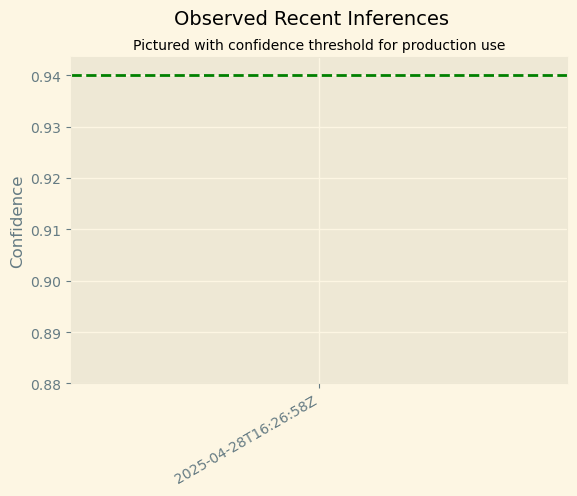

In [210]:
# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inferences, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

### Todo: build your own visualization


In [211]:
# simple_getter returns (inference_list, timestamp)
# inference_list is like [0.87, 0.13], timestamp is an ISO string

x = []
y = []
for obj in json_data:
    inferences, timestamp = simple_getter(obj)
    x.append(timestamp)            # e.g. "2025-04-28T16:26:58Z"
    y.append(max(inferences))      # pick the higher of the two class scores

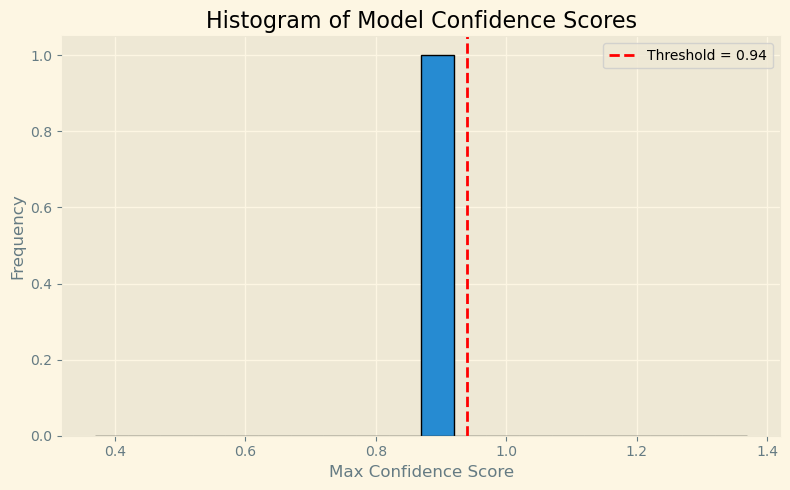

In [212]:
threshold = 0.94

plt.figure(figsize=(8, 5))
plt.hist(y, bins=20, edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.xlabel("Max Confidence Score")
plt.ylabel("Frequency")
plt.title("Histogram of Model Confidence Scores")
plt.legend()
plt.tight_layout()
plt.show()


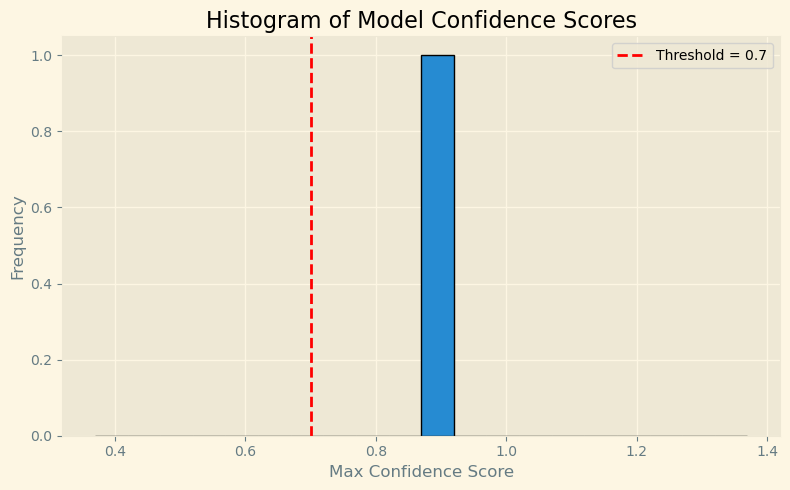

In [213]:
threshold = 0.7

plt.figure(figsize=(8, 5))
plt.hist(y, bins=20, edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.xlabel("Max Confidence Score")
plt.ylabel("Frequency")
plt.title("Histogram of Model Confidence Scores")
plt.legend()
plt.tight_layout()
plt.show()

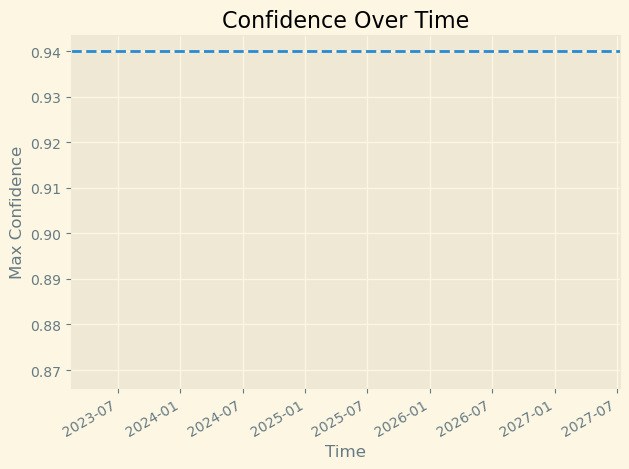

In [214]:
import matplotlib.pyplot as plt
from datetime import datetime

# Extract timestamps and max confidence
timestamps, scores = [], []
for obj in json_data:
    inf, ts = simple_getter(obj)
    timestamps.append(datetime.fromisoformat(ts.replace("Z", "+00:00")))
    scores.append(max(inf))

# Sort by time
times, vals = zip(*sorted(zip(timestamps, scores)))

plt.figure()
plt.plot(times, vals)
plt.axhline(0.94, linestyle="--")  # your threshold
plt.xlabel("Time")
plt.ylabel("Max Confidence")
plt.title("Confidence Over Time")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### Boxplot: Pass vs. Fail Distribution

/tmp/ipykernel_227/2816538196.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([below, above], labels=["Below Threshold", "Above Threshold"])


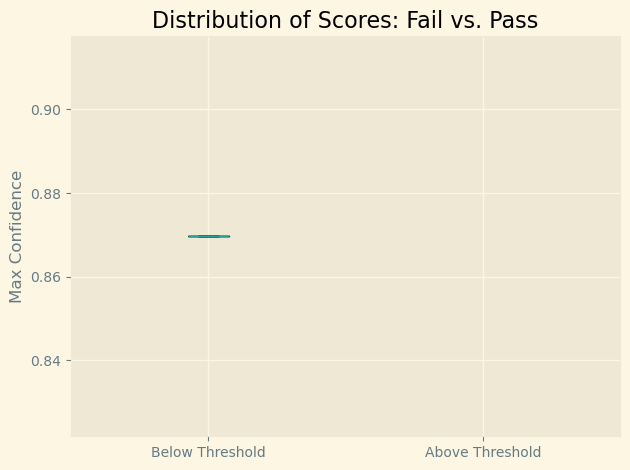

In [215]:
# Split into below/above threshold
threshold = 0.94
below = [max(simple_getter(obj)[0]) for obj in json_data if max(simple_getter(obj)[0]) < threshold]
above = [max(simple_getter(obj)[0]) for obj in json_data if max(simple_getter(obj)[0]) >= threshold]

plt.figure()
plt.boxplot([below, above], labels=["Below Threshold", "Above Threshold"])
plt.ylabel("Max Confidence")
plt.title("Distribution of Scores: Fail vs. Pass")
plt.tight_layout()
plt.show()

### Bar Chart: Count of Pass/Fail

Max score: 0.8696683049201965
Min score: 0.8696683049201965
Pass count: 0
Fail count: 1


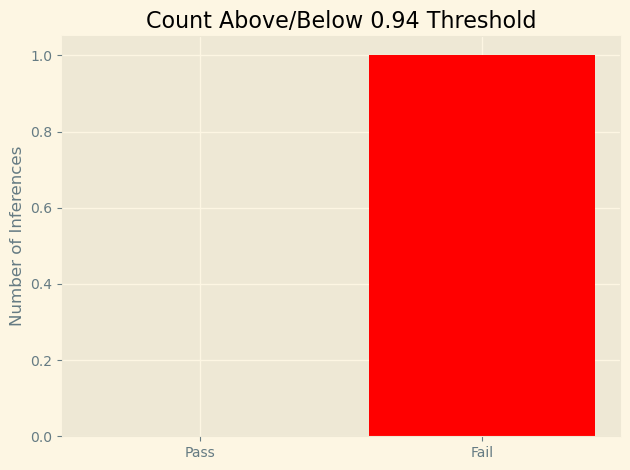

In [217]:
# First, check the max score
print(f"Max score: {max(scores)}")
print(f"Min score: {min(scores)}")

# Check how many values are above the threshold
pass_count = sum(1 for s in scores if s >= threshold)
fail_count = len(scores) - pass_count

print(f"Pass count: {pass_count}")
print(f"Fail count: {fail_count}")

# If fail_count is too high, maybe the threshold is too high; you can try adjusting it.
plt.figure()
plt.bar(["Pass", "Fail"], [pass_count, fail_count], color=['green', 'red'])
plt.ylabel("Number of Inferences")
plt.title(f"Count Above/Below {threshold} Threshold")
plt.tight_layout()
plt.show()

Threshold: 0.7
Pass count (≥ 0.7): 1
Fail count (< 0.7): 0


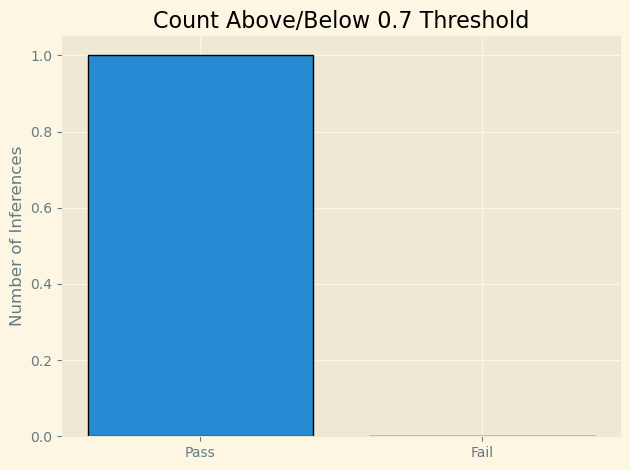

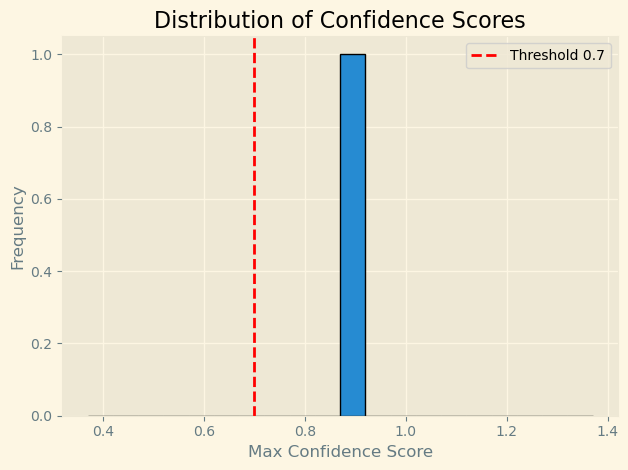

In [218]:
# assume `scores` is your list of max-confidence values from simple_getter/json_data

threshold = 0.7

# 1) Recompute counts
pass_count = sum(1 for s in scores if s >= threshold)
fail_count = len(scores) - pass_count

print(f"Threshold: {threshold}")
print(f"Pass count (≥ {threshold}): {pass_count}")
print(f"Fail count (< {threshold}): {fail_count}")

# 2) Bar chart of pass vs fail
import matplotlib.pyplot as plt

plt.figure()
plt.bar(
    ["Pass", "Fail"],
    [pass_count, fail_count],
    edgecolor="black"
)
plt.ylabel("Number of Inferences")
plt.title(f"Count Above/Below {threshold} Threshold")
plt.tight_layout()
plt.show()

# 3) Histogram of all scores with threshold line
plt.figure()
plt.hist(scores, bins=20, edgecolor="black")
plt.axvline(x=threshold, color="r", linestyle="--", label=f"Threshold {threshold}")
plt.xlabel("Max Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Confidence Scores")
plt.legend()
plt.tight_layout()
plt.show()

### Congratulations!

You've reached the end of the project. In this project you created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. You used the SageMaker Estimator API to deploy your SageMaker Model and Endpoint, and you used AWS Lambda and Step Functions to orchestrate your ML workflow. Using SageMaker Model Monitor, you instrumented and observed your Endpoint, and at the end of the project you built a visualization to help stakeholders understand the performance of the Endpoint over time. If you're up for it, you can even go further with these stretch goals:

* Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.
* Modify your event driven workflow: can you rewrite your Lambda functions so that the workflow can process multiple image inputs in parallel? Can the Step Function "fan out" to accomodate this new workflow?
* Consider the test data generator we provided for you. Can we use it to create a "dummy data" generator, to simulate a continuous stream of input data? Or a big paralell load of data?
* What if we want to get notified every time our step function errors out? Can we use the Step Functions visual editor in conjunction with a service like SNS to accomplish this? Try it out!


